<a href="https://colab.research.google.com/github/ChoiDae1/2022_CVLAB_Winter_Study/blob/main/PyTorch/Image%20and%20Video/Transfer_Learning_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Load Data

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 244 training images. There are 153 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [21]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/hymenoptera_data/hymenoptera_data'
# Dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# DataLoader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
device

device(type='cuda', index=0)

## Visualizing a few images

In [23]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # 0 ~ 1 사이값으로 만들어줌
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

train_imgs, classes = next(iter(dataloaders['train']))
print(train_imgs.shape)

torch.Size([4, 3, 224, 224])


torch.Size([3, 228, 906])


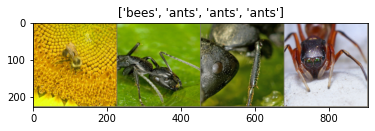

In [24]:
out = torchvision.utils.make_grid(train_imgs)
print(out.shape)

imshow(out, title = [class_names[x] for x in classes ])

In [25]:
print(len(dataloaders['train'])) # number of batches 
print(dataset_sizes)

61
{'train': 244, 'val': 153}


## Training the model

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_weight = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



In [42]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return 

        model.train(mode=was_training)

## Finetuning the convnet (train all)

In [28]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

In [29]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 0.6173 Acc: 0.6885
val Loss: 0.2797 Acc: 0.8954

Epoch 2/25
----------
train Loss: 0.4254 Acc: 0.8402
val Loss: 0.2184 Acc: 0.9412

Epoch 3/25
----------
train Loss: 0.3528 Acc: 0.8770
val Loss: 0.2539 Acc: 0.9150

Epoch 4/25
----------
train Loss: 0.3282 Acc: 0.8852
val Loss: 0.2960 Acc: 0.9020

Epoch 5/25
----------
train Loss: 0.6052 Acc: 0.7459
val Loss: 0.3200 Acc: 0.8758

Epoch 6/25
----------
train Loss: 0.4639 Acc: 0.8238
val Loss: 0.2771 Acc: 0.8889

Epoch 7/25
----------
train Loss: 0.4829 Acc: 0.8402
val Loss: 0.2239 Acc: 0.9020

Epoch 8/25
----------
train Loss: 0.3811 Acc: 0.8443
val Loss: 0.1849 Acc: 0.9412

Epoch 9/25
----------
train Loss: 0.3263 Acc: 0.8566
val Loss: 0.1915 Acc: 0.9346

Epoch 10/25
----------
train Loss: 0.2479 Acc: 0.9016
val Loss: 0.2040 Acc: 0.9216

Epoch 11/25
----------
train Loss: 0.2919 Acc: 0.8689
val Loss: 0.1821 Acc: 0.9346

Epoch 12/25
----------
train Loss: 0.3511 Acc: 0.8566
val Loss: 0.2026 Acc: 0.9216

E

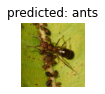

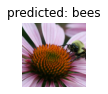

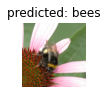

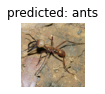

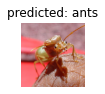

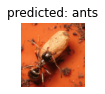

In [43]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

In [39]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

In [40]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 0.3979 Acc: 0.8361


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.2205 Acc: 0.9477

Epoch 2/25
----------
train Loss: 0.3562 Acc: 0.8566
val Loss: 0.2144 Acc: 0.9412

Epoch 3/25
----------
train Loss: 0.3765 Acc: 0.8607
val Loss: 0.2159 Acc: 0.9412

Epoch 4/25
----------
train Loss: 0.3015 Acc: 0.8852
val Loss: 0.2319 Acc: 0.9281

Epoch 5/25
----------
train Loss: 0.5004 Acc: 0.8320
val Loss: 0.2240 Acc: 0.9542

Epoch 6/25
----------
train Loss: 0.4327 Acc: 0.8320
val Loss: 0.2101 Acc: 0.9477

Epoch 7/25
----------
train Loss: 0.2881 Acc: 0.8770
val Loss: 0.2223 Acc: 0.9477

Epoch 8/25
----------
train Loss: 0.4517 Acc: 0.8402
val Loss: 0.2320 Acc: 0.9412

Epoch 9/25
----------
train Loss: 0.4684 Acc: 0.7869
val Loss: 0.2456 Acc: 0.9346

Epoch 10/25
----------
train Loss: 0.3361 Acc: 0.8607
val Loss: 0.2311 Acc: 0.9216

Epoch 11/25
----------
train Loss: 0.3707 Acc: 0.8443
val Loss: 0.2178 Acc: 0.9346

Epoch 12/25
----------
train Loss: 0.3774 Acc: 0.8156
val Loss: 0.2103 Acc: 0.9281

Epoch 13/25
----------
train Loss: 0.4592 Acc: 0.8033


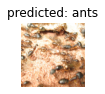

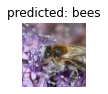

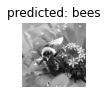

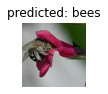

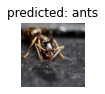

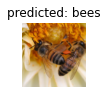

In [44]:
visualize_model(model_ft)